# Variational inference 
#### Basics: Evidence Lower Bound (ELBO) & Coordinate Ascent Variational Inference (CAVI) 

In [1]:
"""""""""""""""""
Required packages
"""""""""""""""""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

### Mixture of Gaussian distributions

Following ``Variational Inference: A Review for Statisticians, Blei et al; (2017)``, consider a Bayesian mixture of unit-variance univariate Gaussians. 

There are $K$ mixture components, each component $k$ of the mixture is a Gaussian distribution with mean $\mu_k$ and variance 1. The random variables $\mu = (\mu_k)_{1\leqslant k \leqslant K}$ are assumed to be independent and identically distributed (i.i.d.) with Gaussian distribution with mean 0 and variance $\sigma^2$. The weight of each mixture component $k$ written $\omega_k$. Conditionally on $\mu$, the observations $(X_i)_{1\leqslant i\leqslant n}$ are assumed to be i.i.d. with probability density:

$$
p(x|\mu) = \sum_{k=1}^K \omega_k \varphi_{\mu_k,1}(x)\,,
$$

where $\varphi_{\mu_k,\sigma^2}$ is the Gaussian probability function with mean $\mu_k$ and variance $\sigma^2$. The likelihood is then given by:

$$
p(x_1,\cdots,x_n) = \int p(x_1,\cdots,x_n|\mu) p(\mu) \mathrm{d} \mu = \int \prod_{i=1}^n p(x_i|\mu) p(\mu) \mathrm{d} \mu = \int \prod_{i=1}^n \left(\sum_{k=1}^K \omega_k \varphi_{\mu_k,1}(x_i)\right) p(\mu) \mathrm{d} \mu
$$

Application with $K= 3$, $\sigma^2 = 5$, $\omega_k = 1/K$ for all $1\leqslant k \leqslant K$.

In [2]:
# Sample data
K  = 3 # number of mixture components
mu = np.random.normal(0,np.sqrt(5),3) # means of the distribution in each cluster
n_samples = 1000 # number of samples

In [3]:
idx = np.random.randint(0,K,n_samples)
np.random.seed(0)
# here mu[idx], when idx is an integer array, returns an array of the mu values indexed by idx
X = np.random.normal(0, 1, n_samples) + mu[idx]

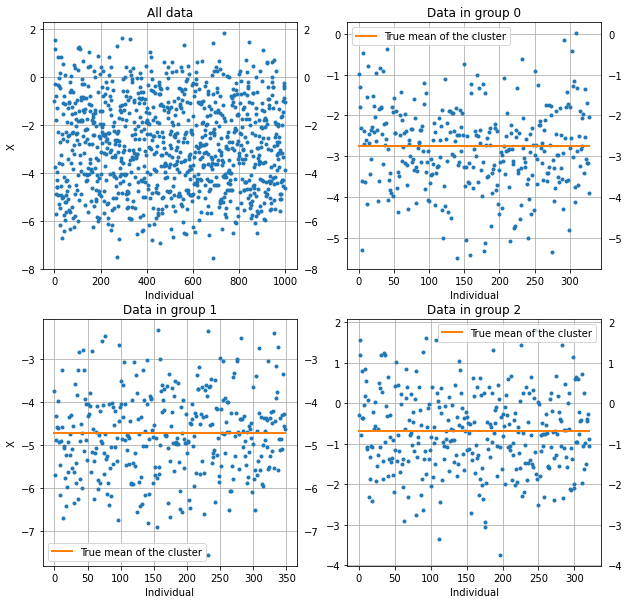

In [4]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(X, '.')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Individual')
plt.ylabel('X')
plt.title('All data')
plt.subplot(2,2,2)
plt.plot(X[idx==0], '.')
plt.plot(np.arange(np.size(X[idx==0])),mu[0]*np.ones(np.size(X[idx==0])), linewidth=2, label = 'True mean of the cluster')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Individual')
plt.title('Data in group 0')
plt.legend()
plt.subplot(2,2,3)
plt.plot(X[idx==1], '.')
plt.plot(np.arange(np.size(X[idx==1])),mu[1]*np.ones(np.size(X[idx==1])), linewidth=2, label = 'True mean of the cluster')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Individual')
plt.ylabel('X')
plt.title('Data in group 1')
plt.legend()
plt.subplot(2,2,4)
plt.plot(X[idx==2], '.')
plt.plot(np.arange(np.size(X[idx==2])),mu[2]*np.ones(np.size(X[idx==2])), linewidth=2, label = 'True mean of the cluster')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Individual')
plt.title('Data in group 2')
plt.legend();

Our aim is to approximate the posterior distribution $p(\mu,c|x)$ where $c = (c_1,\cdots,c_n)$ are the mixture components of the observations.  The mean-field variational family is described as follows:

$$
q(\mu,c) = \prod_{k=1}^K \varphi_{m_k,s_k}(\mu_k)\prod_{i=1}^n \mathrm{Cat}_{\phi_i}(c_i)\,, 
$$

which means that:

- $\mu$ and $c$ are independent.
- $(\mu_{k})_{1\leqslant k \leqslant K}$ are independent with Gaussian distribution with means $(m_{k})_{1\leqslant k \leqslant K}$ and variances $(s_{k})_{1\leqslant k \leqslant K}$.
- $(c_{i})_{1\leqslant i \leqslant n}$ are independent with multinomial distribution with parameters $(\phi_i)_{1\leqslant i \leqslant n}$: $q(c_i=k) = \phi_i(k)$ for $1\leqslant k \leqslant K$. 

Write $\mathcal{D}$ the family of such distributions when $(m_{k})_{1\leqslant k \leqslant K}\in \mathbb{R}^K$, variances $(s_{k})_{1\leqslant k \leqslant K}\in (\mathbb{R}_+^*)^K$ and $(\phi_i)_{1\leqslant i \leqslant n}\in \mathcal{S}_K^n$ where $\mathcal{S}_K$ is the $K$-dimensional probability simplex. 

The objective is now to find the
"best candidate" in $\mathcal{D}$ to approximate $p(\mu,c|x)$, i.e. the one ``which minimizes the following KL divergence``:

$$
q^* = \mathrm{Argmin}_{q\in\mathcal{D}} \mathrm{KL}\left(q(\mu,c)\|p(\mu,c|x)\right)\,.
$$

Note that
\begin{align*}
\mathrm{KL}\left(q(\mu,c)\|p(\mu,c|x)\right) &= \mathbb{E}_q[\log q(\mu,c)] - \mathbb{E}_q[\log p(\mu,c|x)]\,,\\
 &= \mathbb{E}_q[\log q(\mu,c)] - \mathbb{E}_q[\log p(\mu,c,x)]+\log p(x)\,,\\
&= -\mathrm{ELBO}(q)+\log p(x)\,,
\end{align*}

where the ``Evidence Lower Bound`` (ELBO) is

$$
\mathrm{ELBO}(q) = -\mathbb{E}_q[\log q(\mu,c)] + \mathbb{E}_q[\log p(\mu,c,x)] \,.
$$

Therefore, ``minimizing the KL divergence`` boils down to maximizing the ELBO, where $\log p(x)\geqslant \mathrm{ELBO}(q)$.

The complexity of the family $\mathcal{D}$ determines the complexity of the optimization.

### Generic CAVI algorithm

Detail here why the algorithm computes iteratively for all $1\leqslant k \leqslant K$,

$$
q(\mu_k) \propto \mathrm{exp}\left(\mathbb{E}_{\tilde q_{\mu_k}}[\log \tilde p_k(\mu_k|x)]\right)
$$

and for all $1\leqslant i \leqslant n$,

$$
q(c_i) \propto \mathrm{exp}\left(\mathbb{E}_{\tilde q_{c_i}}[\log \tilde p_i(c_i|x)]\right)\,,
$$

where 

- $\tilde p_i(c_i|x)$ is the conditional distribution of $c_i$ given the observations and all the other parameters and $\tilde p_k(\mu_k|x)$ is the conditional distribution of $\mu_k$ given the observations and all the other parameters.

- $\mathbb{E}_{\tilde q_z}$ is the expectation under the variational law of all parameters except $z$.

### Application to the mixture of Gaussian distributions

As $\tilde p_i(c_i|x)$ be the conditional distribution of $c_i$ given the observations and the other parameters.

$$
\tilde p_i(c_i|x) \propto p(c_i)p(x_i|c_i,\mu) \propto p(c_i)\prod_{k=1}^K \left(\varphi_{\mu_k,1}(x_i)\right)^{1_{c_i=k}}\,. 
$$

Therefore,

$$
\mathbb{E}_{\tilde q_{c_i}}[\log \tilde p_i(c_i|x)] = \log p(c_i) + \sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[\log \varphi_{\mu_k,1}(x_i)]
$$

and

\begin{align*}
\mathrm{exp}\left(\mathbb{E}_{\tilde q_{c_i}}[\log \tilde p_i(c_i|x)]\right) &\propto p(c_i) \mathrm{exp}\left(\sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[\log \varphi_{\mu_k,1}(x_i)]\right)\,\\
&\propto p(c_i) \mathrm{exp}\left(\sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[-(x_i-\mu_k)^2/2]\right)\,\\
&\propto p(c_i) \mathrm{exp}\left(\sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[-(x_i-\mu_k)^2/2]\right)\,.
\end{align*}

The update is then written:

$$
\varphi_i(k) \propto p(c_i=k) \mathrm{exp}\left(m_k x_i - \frac{m^2_k + s_k}{2}\right)\,.
$$

### Update of $(\phi_i)_{1\leqslant i \leqslant n}$ using CAVI

In [5]:
def CAVI_update_phi(X,m,s2):
    
    first_term_mean = np.outer(X, m)
    second_term_mean = -(m**2 + s2)/2
    
    phi = np.exp(first_term_mean + second_term_mean[np.newaxis, :])
    phi = phi / phi.sum(1)[:, np.newaxis]
    
    return phi

As $\tilde p_k(\mu_k|x)$ be the conditional distribution of $\mu_k$ given the observations and the other parameters.

$$
\tilde p_k(\mu_k|x) \propto p(\mu_k)\prod_{i=1}^np(x_i|c_i,\mu) \propto p(\mu_k)\prod_{i=1}^n p(x_i|\mu,c_i)\,. 
$$

Therefore,

$$
\mathbb{E}_{\tilde q_{\mu_k}}[\log \tilde p_k(\mu_k|x)] = \log p(\mu_k) + \sum_{i=1}^n \mathbb{E}_{\tilde q_{\mu_k}}[\log p(x_i|\mu,c_i)]
$$

and

\begin{align*}
\mathrm{exp}\left(\mathbb{E}_{\tilde q_{\mu_k}}[\log \tilde p_i(c_i|x)]\right) &\propto p(\mu_k) \mathrm{exp}\left(\sum_{i=1}^n\sum_{k=1}^K  \mathbb{E}_{\tilde q_{\mu_k}}[1_{c_i=k}\log \varphi_{\mu_k,1}(x_i)]\right)\,\\
&\propto p(\mu_k) \mathrm{exp}\left(\sum_{i=1}^n \phi_i(k) \mathbb{E}_{\tilde q_{\mu_k}}[\log \varphi_{\mu_k,1}(x_i)]\right)\,\\
&\propto \mathrm{exp}\left(-\frac{\mu_k^2}{2\sigma^2}-\frac{1}{2}\sum_{i=1}^n \phi_i(k)(x_i-\mu_k)^2\right)\,,\\
&\propto \mathrm{exp}\left(-\frac{\mu_k^2}{2\sigma^2}+\sum_{i=1}^n \phi_i(k)x_i\mu_k - \frac{1}{2}\sum_{i=1}^n \phi_i(k)\mu^2_k\right)\,.
\end{align*}

The update is then written:

$$
\mu_k = \frac{\sum_{i=1}^n \phi_i(k)x_i}{1/\sigma^2 + \sum_{i=1}^n \phi_i(k)}\quad\mathrm{and}\quad s_k = \frac{1}{1/\sigma^2 + \sum_{i=1}^n \phi_i(k)}\,. 
$$

### Update of $(m_{k})_{1\leqslant k \leqslant K}$ and $(s_{k})_{1\leqslant k \leqslant K}$ using CAVI

In [6]:
def CAVI_update_mu_s2(X,m,phi,s2,sigma2,K):
    
    m  = (phi*X[:, np.newaxis]).sum(0) * (1/sigma2 + phi.sum(0))**(-1)
    s2 = (1/sigma2 + phi.sum(0))**(-1)
    
    return m, s2

In [7]:
def elbo(X,phi,m,s2,sigma2):
        
        first_term  = (0.5*np.log(s2) - m**2/sigma2).sum()
        second_term = (-0.5*(s2+m**2) + np.outer(X, m) - np.log(phi))*phi

        return first_term + second_term.sum()

In [8]:
def CAVI_mixture_Gaussian(X,m, s2, phi, sigma2, max_iter = 500, epsilon = 1e-8):
        
        elbos  = [elbo(X,phi,m,s2,sigma2)]
        m_est  = [m]
        s2_est = [s2]
        
        for it in range(1, max_iter+1):
            
            phi   = CAVI_update_phi(X,m,s2)
            m, s2 = CAVI_update_mu_s2(X,m,phi,s2,sigma2,K)
            
            m_est.append(m)
            s2_est.append(s2)
            
            elbos.append(elbo(X,phi,m,s2,sigma2))

            if np.abs(elbos[-2] - elbos[-1]) <= epsilon:
                break
        
        return elbos, m_est, s2_est

### Run the algorithm

In [9]:
# Initialization
phi_init = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*K, n_samples)
m_init = np.random.normal(0, 1, K)
s2_init = np.ones(K) * np.random.random(K)

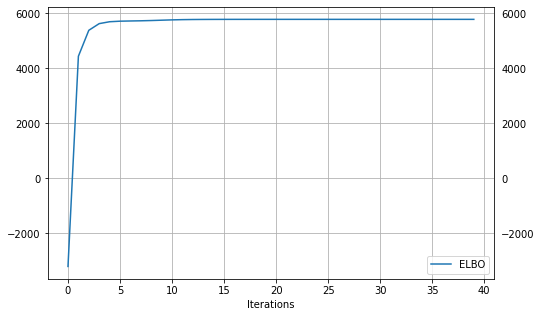

In [10]:
fig = plt.figure(figsize=(8,5))
elbos, m_est, s2_est = CAVI_mixture_Gaussian(X, m_init, s2_init, phi_init, 3, 500, 0.0001)
plt.plot(np.array(elbos),label = 'ELBO')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Iterations')
plt.legend();

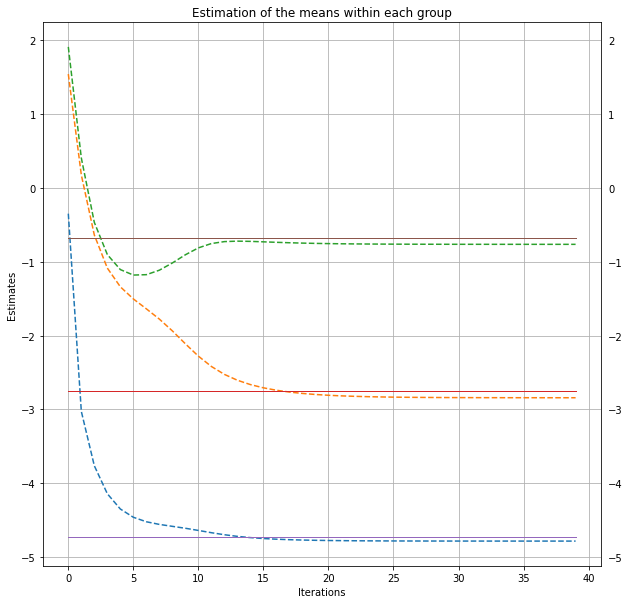

In [11]:
# Convergence of the estimators
nb_iter = np.array(elbos).size # number of iterations before stopping criterion
fig = plt.figure(figsize=(10,10))
plt.plot(m_est, '--')
plt.plot(np.arange(nb_iter),mu[0]*np.ones(nb_iter), linewidth=1, label = 'True mean of the cluster 0')
plt.plot(np.arange(nb_iter),mu[1]*np.ones(nb_iter), linewidth=1, label = 'True mean of the cluster 1')
plt.plot(np.arange(nb_iter),mu[2]*np.ones(nb_iter), linewidth=1, label = 'True mean of the cluster 2')
plt.tick_params(labelright=True)
plt.grid(True)
plt.ylabel('Estimates')
plt.xlabel('Iterations')
plt.title('Estimation of the means within each group');

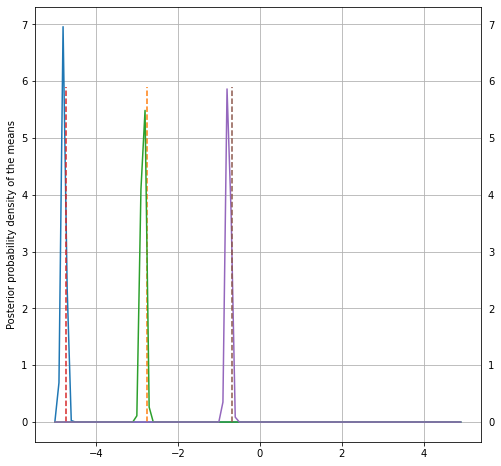

In [12]:
# Posterior distribution of the means in each group
from scipy.stats import norm
plt.figure(figsize=(8,8))
x_axis = np.arange(-5, 5, 0.1)
y_axis = np.arange(0, 6, 0.1)
plt.plot(x_axis, norm.pdf(x_axis,m_est[-1][0],np.sqrt(s2_est[-1][0])))
plt.plot(mu[0]*np.ones(np.size(y_axis)), y_axis, '--')
plt.plot(x_axis, norm.pdf(x_axis,m_est[-1][1],np.sqrt(s2_est[-1][1])))
plt.plot(mu[1]*np.ones(np.size(y_axis)), y_axis, '--')
plt.plot(x_axis, norm.pdf(x_axis,m_est[-1][2],np.sqrt(s2_est[-1][2])))
plt.plot(mu[2]*np.ones(np.size(y_axis)), y_axis, '--')
plt.tick_params(labelright=True)
plt.grid(True)
plt.ylabel('Posterior probability density of the means');

### Sensitivity to initialization

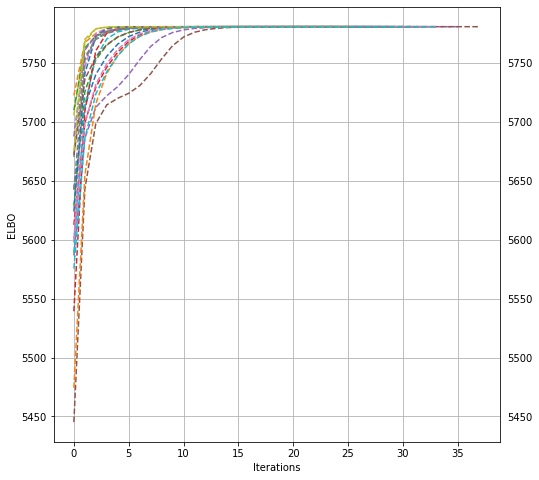

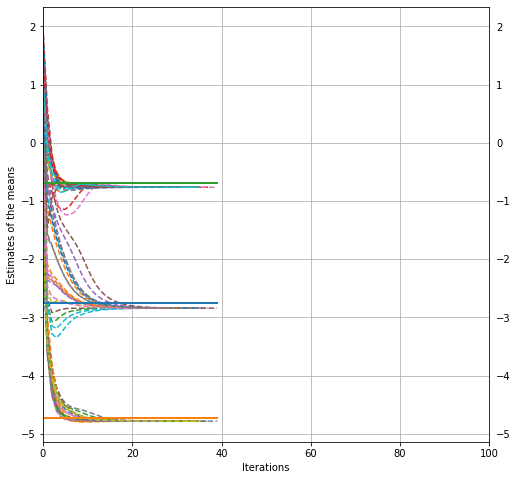

In [13]:
nb_iter_max = 0
for _ in range(20):
    # Initialization
    phi_init = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*K, n_samples)
    m_init = np.random.normal(0, 1, K)
    s2_init = np.ones(K) * np.random.random(K)
    elbos, m_est, s2_est = CAVI_mixture_Gaussian(X, m_init, s2_init, phi_init, 3, 500, 0.0001)
    nb_iter = np.array(elbos).size
    if nb_iter>nb_iter_max:
        nb_iter_max = nb_iter
    plt.figure(0, figsize=(8,8))
    plt.plot(np.array(elbos[2::]), '--')
    plt.tick_params(labelright=True)
    plt.grid(True)
    plt.xlabel('Iterations')
    plt.ylabel('ELBO')
    plt.figure(1, figsize=(8,8))
    plt.plot(m_est,'--')
    plt.tick_params(labelright=True)
    plt.grid(True)
    plt.xlabel('Iterations')
    plt.ylabel('Estimates of the means')

plt.figure(1)
plt.xlim([0,100])
plt.plot(np.arange(nb_iter_max),mu[0]*np.ones(nb_iter_max), linewidth=2, label = 'True mean of the cluster 0')
plt.plot(np.arange(nb_iter_max),mu[1]*np.ones(nb_iter_max), linewidth=2, label = 'True mean of the cluster 1')
plt.plot(np.arange(nb_iter_max),mu[2]*np.ones(nb_iter_max), linewidth=2, label = 'True mean of the cluster 2');